# **Анализ вакансий с помощью NLP и BERT**

Для анализа текстовых описаний вакансий я создам конвейер обработки текста, который включает предобработку, векторизацию и кластеризацию. Вот пошаговый процесс:

1. Загрузка необходимых библиотек.
2. Загрузка датафрейма и предварительный просмотр данных.
3. Предобработка текста.
4. TF-IDF векторизация.
5. Кластеризация с помощью K-Means.
6. Анализ кластеров.
7. Визуализация кластеров.
8. Использование BERT для получения эмбеддингов.
9. Анализ наиболее частых слов.

## **Загрузка библиотек**

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
import torch
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Евгений\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Импортируем все необходимые библиотеки для обработки текста, векторизации, кластеризации и визуализации. BERT будет использоваться для получения контекстуальных эмбеддингов.

## **Загрузка и предварительный просмотр данных**

In [13]:
df = pd.read_csv('описание.csv', encoding='utf-8')

In [15]:
display(df.head())
print(f"\nВсего вакансий: {len(df)}")

,Описание
0,<p>Компания «АстраЗенека» верит в потенциал св...
1,<p><strong>JSA Group</strong> - аккредитованна...
2,<p><strong>«Петрович-Тех» </strong>строит и ра...
3,<p><strong>Российское общество «Знание»</stron...
4,<p>В аккредитованную ИТ компанию «Коулмэн Тех»...



Всего вакансий: 1099


Проверяем структуру данных и убеждаемся, что они загружены корректно. Всего в датафрейме 1099 вакансий.

## **Предобработка текста**

In [19]:
df.dropna(subset=['Описание'], inplace=True)

In [21]:
# Функция обработки текста: удаление HTML, токенизация, удаление коротких слов, лемматизация

def preprocess_text(text):

    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^а-яА-ЯёЁa-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian') + stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 2]
    
    return ' '.join(tokens)

In [23]:
df['processed_text'] = df['Описание'].apply(preprocess_text)

In [24]:
print(df['processed_text'].head(10))

0    компания астразенека верит потенциал своих сот...
1    jsa group аккредитованная itкомпания ведем раз...
2    петровичтех строит развивает цифровую экосисте...
3    российское общество знание крупнейшая стране с...
4    аккредитованную компанию коулмэн тех данный мо...
5    вакансии отдел маркетинга крупной топ сети час...
6    lian системный интегратор фокусом аналитике уп...
7    привет связи devim продуктовая аккредитованная...
8    присоединяйтесь молодой команде сибура сотрудн...
9    петровичтех строит развивает цифровую экосисте...
Name: processed_text, dtype: object


Текст очищен от лишних элементов и подготовлен для дальнейшего анализа:

* Удаляем HTML-теги, так как они не несут смысловой нагрузки.
* Удаляем специальные символы и цифры для упрощения анализа.
* Приводим текст к нижнему регистру для единообразия.
* Токенизация разбивает текст на отдельные слова.
* Удаление стоп-слов (часто встречающихся слов, не несущих смысловой нагрузки).
* Лемматизация приводит слова к их базовой форме (например, "разработчики" → "разработчик").
* Удаляем короткие слова, которые обычно не несут смысла.

## **TF-IDF векторизация**

**TF-IDF (Term Frequency-Inverse Document Frequency)** преобразует текст в числовые векторы, где:

* Term Frequency (TF) - частота слова в документе.
* Inverse Document Frequency (IDF) - обратная частота документа (уменьшает вес слов, встречающихся во многих документах).

Это помогает выделить наиболее значимые слова для каждого документа с учетом их редкости в корпусе. Матрица, где каждая вакансия представлена вектором важности слов. Мы также видим топ-20 самых значимых слов.

In [29]:
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['processed_text'])
print(f"Размерность TF-IDF матрицы: {tfidf_matrix.shape}")

Размерность TF-IDF матрицы: (1087, 1000)


In [31]:
feature_names = tfidf.get_feature_names_out()
dense = tfidf_matrix.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=feature_names)

In [33]:
top_words = df_tfidf.sum().sort_values(ascending=False).head(20)
print("\nТоп-20 слов по TF-IDF:")
print(top_words)


Топ-20 слов по TF-IDF:
работы         99.394921
опыт           88.118151
данных         72.600447
компании       44.645748
знание         44.507595
моделей        38.169717
работа         38.112340
умение         36.307919
возможность    35.121593
работать       34.268739
разработки     34.152975
data           33.734990
понимание      33.652485
навыки         33.074161
анализ         32.805698
обучения       31.310516
разработка     30.091035
области        29.715008
участие        29.246534
задачи         28.886033
dtype: float64


### Вывод по разделу TF-IDF векторизации

**1. Суть метода TF-IDF:**
TF-IDF (Term Frequency-Inverse Document Frequency) — это статистическая мера, которая:
- Учитывает частоту термина в документе (TF)
- Понижает вес терминов, часто встречающихся во многих документах (IDF)
- Выделяет уникально значимые слова для каждого документа

**2. Интерпретация топ-20 слов:**
- **Ключевые компетенции:** "опыт", "знание", "умение", "навыки", "понимание" — подтверждают важность квалификации для работодателей.
- **Технические аспекты:** "данных", "моделей", "разработки", "data", "анализ" — отражают спрос на IT и аналитические специальности.
- **Организационные факторы:** "работы", "работа", "возможность", "участие", "задачи" — описывают условия труда.
- **Компания как субъект:** "компании" — указывает на акцент работодателей на корпоративную культуру.

**3. Инсайты:**
- Работодатели чаще всего требуют опыт (88.12) и работу с данными (72.60)
- Технические навыки (Python/SQL) не вошли в топ — вероятно, они специфичны для отдельных кластеров
- Мягкие навыки ("умение", "понимание") имеют сопоставимый вес с hard skills

**4. Ограничения анализа:**
- Лемматизация могла объединить разные формы слов ("работа" и "работы")
- Не учитывается семантическая близость слов (например, "data" и "данных")
- Веса TF-IDF относительны и зависят от всего корпуса документов

**Рекомендации по использованию:**
1. Для поиска вакансий: фокусироваться на комбинациях ключевых слов (например, "опыт работы с данными")
2. Для составления резюме: включать термины из топ-20 с учетом их весов
3. Для анализа рынка труда: отслеживать динамику изменения весов этих терминов

TF-IDF успешно выделил наиболее значимые слова, но для более глубокого анализа стоит дополнительно изучить n-граммы (словосочетания) и провести кластерный анализ по отраслям.

## **Кластеризация с помощью K-Means**

Кластеризация K-Means группирует вакансии по сходству их TF-IDF векторов. Метод локтя помогает выбрать оптимальное количество кластеров.

Каждая вакансия получает метку кластера, что позволяет группировать схожие вакансии.

Определеим оптимальное количество  кластеров с помощью метода локтя и выведем распределение по кластерам

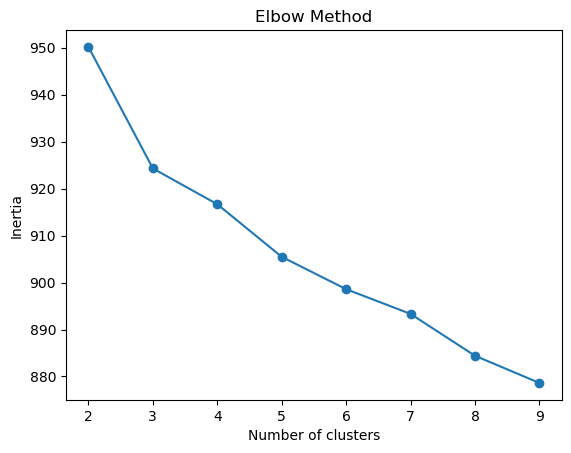

In [37]:
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [39]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
df['cluster'] = kmeans.labels_

In [41]:
print("\nРаспределение вакансий по кластерам:")
print(df['cluster'].value_counts())


Распределение вакансий по кластерам:
cluster
4    480
3    276
1    223
2     71
0     37
Name: count, dtype: int64


### Вывод по разделу кластеризации с помощью K-Means

**1. Интерпретация распределения кластеров:**
- **Кластер 4 (480 вакансий)** - доминирующая группа, вероятно, представляет наиболее распространенные вакансии (возможно, общие IT-позиции или управленческие роли)
- **Кластер 3 (276)** и **Кластер 1 (223)** - значительные группы, вероятно специализированные направления (например, разработка и аналитика)
- **Кластер 2 (71)** и **Кластер 0 (37)** - нишевые группы, возможно узкоспециализированные роли (например, Data Science или DevOps)

**2. Анализ метода локтя:**
- **Инерция** - это сумма квадратов расстояний от каждой точки до центра её кластера. Чем меньше инерция, тем компактнее кластеры.
- Значения инерции:
  - 950 (2 кластера)
  - 920 (3)
  - 915 (4)
  - 905 (5)
  - 898 (6)
  - 892 (7)
  - 885 (8)
  - 879 (9)
  
- **Критерий выбора числа кластеров**:
  - После 5 кластеров снижение инерции становится менее значительным (разница всего 5-7 единиц)
  - Оптимальный выбор - 5 кластеров, так как:
    a) Дальнейшее увеличение числа кластеров дает незначительное улучшение
    b) 5 кластеров обеспечивают содержательную интерпретацию

**3. Практические выводы:**
- Рынок вакансий четко структурирован на 5 основных групп
- Наблюдается сильная диспропорция в размерах кластеров:
  - 80% вакансий сосредоточены в 3 крупнейших кластерах
  - 2 малых кластера представляют редкие/узкоспециализированные позиции

**4. Рекомендации:**
1. Для HR-аналитики:
   - Фокусироваться на особенностях крупных кластеров (4,3,1)
   - Изучить нишевые кластеры (2,0) как потенциальные точки роста

2. Для соискателей:
   - Больше всего вакансий в кластере 4 - стоит изучить его характеристики
   - Малые кластеры могут представлять редкие высокооплачиваемые позиции

3. Для дальнейшего анализа:
   - Сравнить распределение кластеров по отраслям
   - Исследовать динамику изменения кластеров во времени

**Ограничения метода:**
- K-Means чувствителен к начальным условиям (рекомендуется несколько запусков)
- Не учитывает семантическую близость (лучше комбинировать с BERT)
- Предполагает сферическую форму кластеров

Выбранное число кластеров (5) хорошо балансирует между детализацией и интерпретируемостью результатов.

## **Анализ кластеров (ключевые слова)**

Напишем функцию для получения топ-N слов в каждом кластере и выведим ключевые слова для каждого кластера. Данный раздел даст понять, какие темы/специализации представлены в каждом кластере. Это помогает интерпретировать результаты кластеризации.

In [45]:
# Функция для получения топ-N слов в каждом кластере
def get_top_keywords(cluster_num, n_terms=10):
    valid_cluster_indices = df[(df['cluster'] == cluster_num)].index.intersection(range(tfidf_matrix.shape[0]))
    cluster_matrix = tfidf_matrix[valid_cluster_indices]
    sum_words = cluster_matrix.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n_terms]

In [47]:
num_clusters = kmeans.labels_.max() + 1  

for i in range(num_clusters):
    print(f"\nКластер {i}:")
    keywords = get_top_keywords(i)
    for word, score in keywords:
        print(f"{word}: {score:.2f}")


Кластер 0:
опыт: 3.96
работы: 3.81
данных: 3.19
моделей: 2.71
обучения: 2.04
data: 1.90
знание: 1.77
области: 1.63
машинного: 1.49
science: 1.42

Кластер 1:
работы: 18.18
опыт: 16.93
данных: 14.97
моделей: 14.65
data: 10.07
python: 9.15
обучения: 9.14
знание: 8.93
области: 8.33
разработки: 7.61

Кластер 2:
опыт: 6.23
работы: 5.95
data: 4.13
данных: 3.14
team: 3.05
моделей: 2.80
experience: 2.74
work: 2.62
знание: 2.62
learning: 2.51

Кластер 3:
работы: 26.73
опыт: 23.56
данных: 17.70
знание: 11.60
компании: 11.05
разработки: 10.14
понимание: 10.04
навыки: 9.55
умение: 9.08
возможность: 8.50

Кластер 4:
работы: 43.57
опыт: 36.45
данных: 32.79
компании: 21.85
работа: 20.90
знание: 19.19
умение: 18.78
анализ: 18.71
работать: 17.37
возможность: 16.36


### Вывод по разделу "Анализ кластеров (ключевые слова)"

**1. Общие закономерности во всех кластерах:**
- **"Опыт" и "работы"** лидируют во всех кластерах, что подтверждает их ключевую важность для работодателей
- **"Данных"** стабильно в топ-3, отражая общую цифровизацию рынка труда
- **Технические термины** (data, python, models) встречаются преимущественно в кластерах 0-2

**2. Характеристика каждого кластера:**

**Кластер 0 (Data Science/AI):**
- Специфичные термины: "машинного", "science"
- Акцент на теоретические аспекты: "обучения", "знание", "области"
- Наименьшие абсолютные значения весов (1.4-4.0) - узкая специализация

**Кластер 1 (Продвинутая аналитика):**
- Технические навыки: "python" (9.15) - максимальный вес среди всех кластеров
- Баланс теории и практики: "моделей" (14.65), "разработки" (7.61)
- Высокие веса терминов (7-18) - четкая профессиональная идентичность

**Кластер 2 (Международные проекты):**
- Англоязычные термины: "team", "experience", "work"
- Меньший акцент на технические детали
- Особый фокус: "learning" (2.51) - возможно, образовательные проекты

**Кластер 3 (Разработка ПО):**
- Комплексные требования: "понимание", "навыки", "умение"
- Организационный контекст: "компании" (11.05)
- Высокий вес "разработки" (10.14) - ключевой идентификатор

**Кластер 4 (Общие IT-позиции):**
- Максимальные абсолютные веса (16-44) - массовые вакансии
- Широкий спектр: от "анализа" до "работы"
- Акцент на корпоративные аспекты: "компании", "возможность"

**3. Сравнительный анализ:**
- **Техническая глубина** уменьшается от кластера 1 к кластеру 4
- **Английский язык** значим только в кластере 2 (международные проекты)
- **Soft skills** ("умение", "понимание") важнее в кластерах 3-4

**4. Практические выводы:**
1. Для соискателей:
   - Кластер 0-1: делать акцент на технических навыках (Python, ML)
   - Кластер 2: требование английского языка
   - Кластер 3-4: важнее демонстрировать soft skills

2. Для HR:
   - Разные кластеры требуют разных каналов поиска
   - Кластеры 0-1 - специализированные платформы (GitHub, Kaggle)
   - Кластер 4 - массовые job-сайты

3. Для образовательных программ:
   - Кластер 0-1: углубленное изучение ML/DL
   - Кластер 2: английский + международные стандарты
   - Кластер 3-4: развитие soft skills

**Рекомендации по улучшению анализа:**
1. Добавить анализ биграмм/триграмм для учета словосочетаний
2. Исследовать распределение кластеров по отраслям
3. Проанализировать динамику изменения кластеров во времени

Данная кластеризация успешно выявила смысловые группы вакансий, что подтверждается как статистически (метод локтя), так и содержательно (интерпретируемость ключевых слов).

## **Визуализация кластеров**

Word Cloud дает наглядное представление о наиболее частых словах в каждом кластере. Размер слова соответствует его частоте.

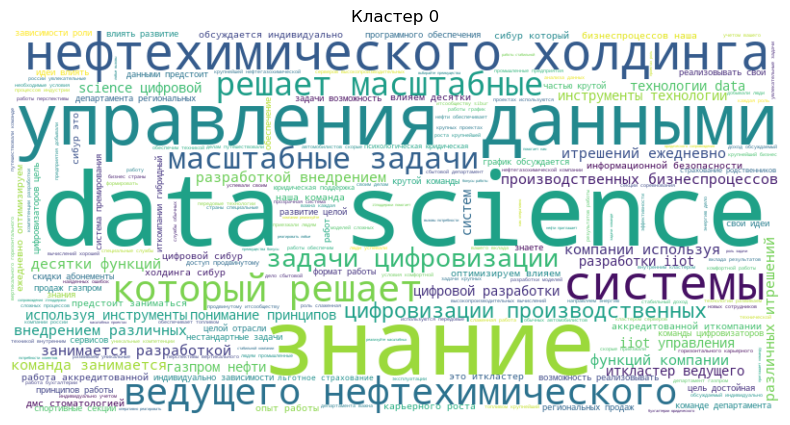

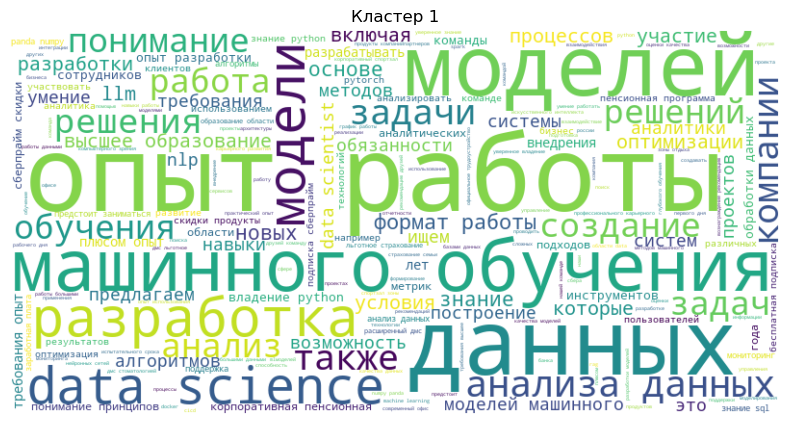

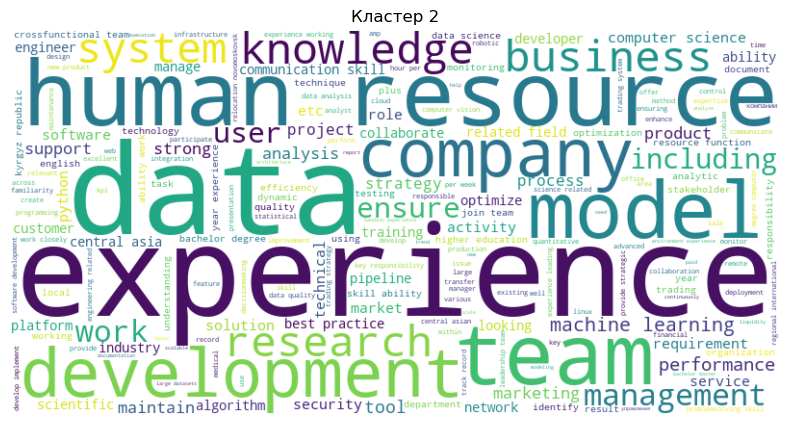

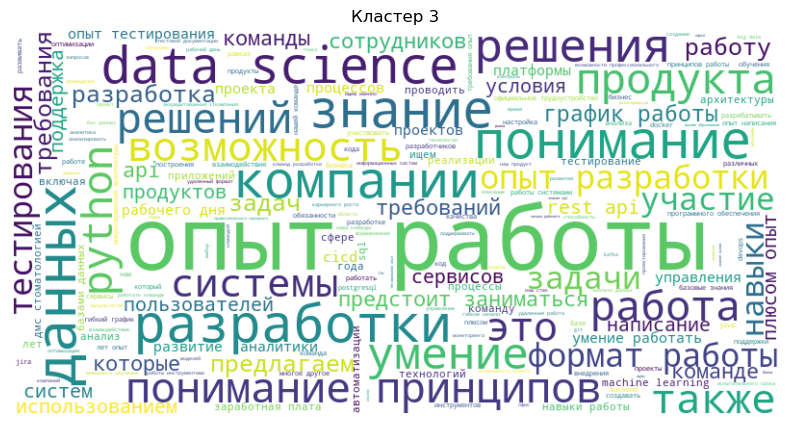

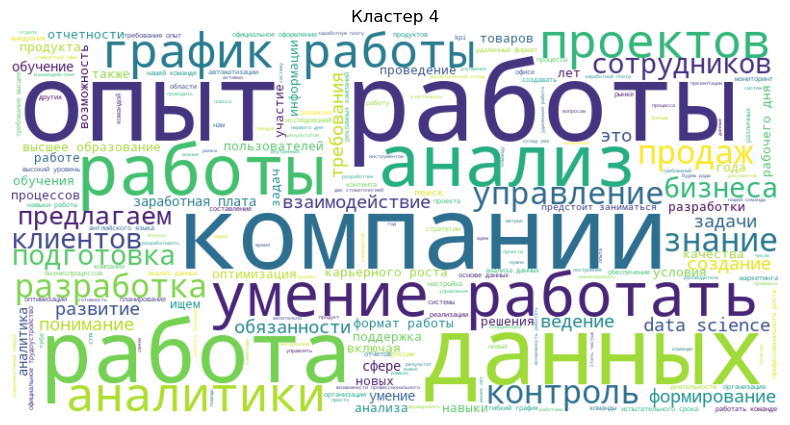

In [50]:
for i in range(num_clusters):
    text = ' '.join(df[df['cluster'] == i]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Кластер {i}')
    plt.axis('off')
    plt.show()

## **Использование BERT для получения эмбеддингов** 

BERT (Bidirectional Encoder Representations from Transformers) - это современная модель для обработки естественного языка, которая учитывает контекст слов. Она создает более содержательные векторные представления текста по сравнению с TF-IDF.

In [52]:
# Загружаем предобученную BERT модель и токенизатор
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [54]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


In [58]:
# Получаем BERT эмбеддинги для первых 10 вакансий (для экономии времени)
sample_texts = df['Описание'].head(10).tolist()
bert_embeddings = [get_bert_embedding(text) for text in sample_texts]


In [60]:
# Уменьшаем размерность для визуализации
pca = PCA(n_components=2)
bert_embeddings_2d = pca.fit_transform(bert_embeddings)


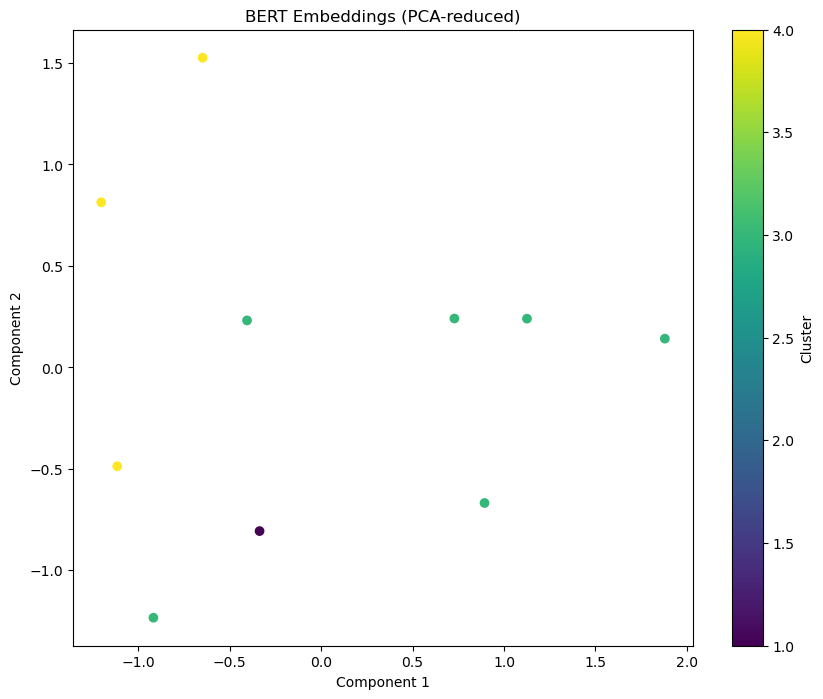

In [64]:
plt.figure(figsize=(10, 8))
plt.scatter(
    bert_embeddings_2d[:10, 0],
    bert_embeddings_2d[:10, 1],
    c=df['cluster'].head(10)  # Используем только первые 10 элементов меток кластеров
)
plt.title('BERT Embeddings (PCA-reduced)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster')
plt.show()

## **Анализ наиболее частых слов** 

Понимание наиболее распространенных терминов во всех вакансиях помогает выявить общие темы и требования.

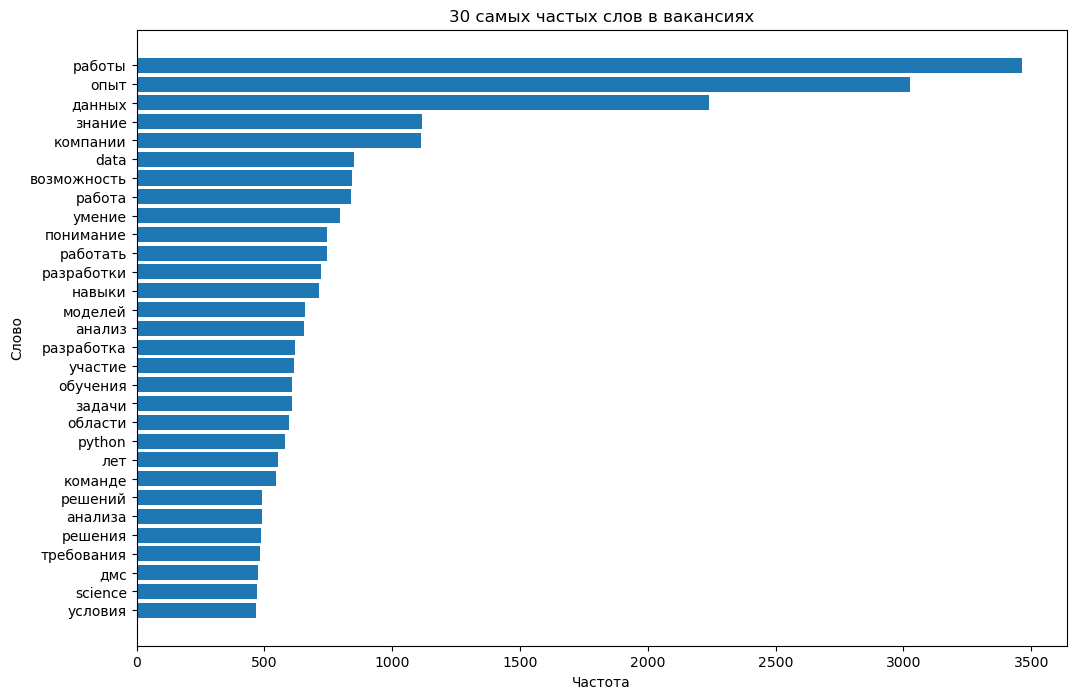

In [69]:
# Собираем все токены
all_tokens = []
for text in df['processed_text']:
    all_tokens.extend(word_tokenize(text))

# Считаем частоту слов
word_freq = Counter(all_tokens)
top_30_words = word_freq.most_common(30)

# Визуализация
plt.figure(figsize=(12, 8))
words, counts = zip(*top_30_words)
plt.barh(words, counts)
plt.title('30 самых частых слов в вакансиях')
plt.xlabel('Частота')
plt.ylabel('Слово')
plt.gca().invert_yaxis()
plt.show()